### Convolution Neural Network (CNN)

- 이전 AE / VAE 에서 보았던 단순 Fully Connected model 은 일자로 데이터를 변형해서, 모델의 입력을 넣고 있다.
- 그런데 이미지에서는 공간적 위치가 굉장히 중요하다.
- 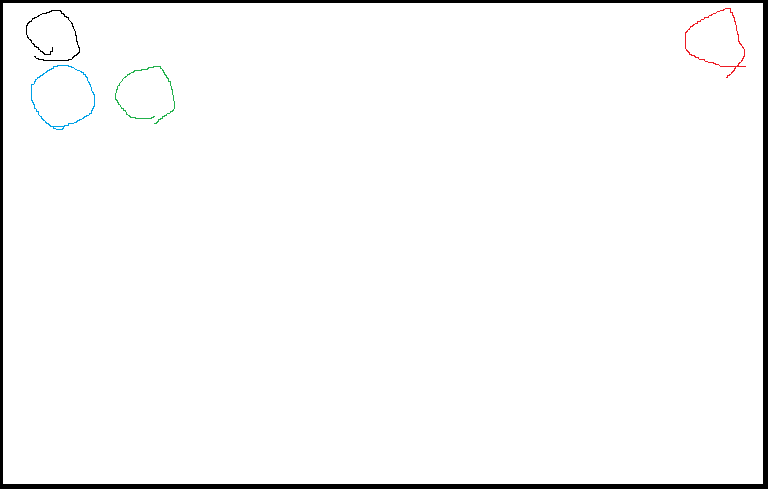
- 이 이미지에서, 검정색 동그라미는, 하늘색, 초록색 동그라미와는 관련성이 깊고, 빨간색 동그라미와는 관계도가 좀 낮다.
- 문제는 이러한 데이터를 1차원으로 펼쳐서 넣게 되면, 공간적인 정보를 잃어버린다.
- CNN은 이러한 문제를 해결한 모델이다.

### CNN의 핵심
#### Convolution (합성 곱)
 - 작은 필터 (커널)을 이미지 전체에 슬라이딩 한다.
 - 커널이 보는 작은 영역을 보고 패턴을 인식
 - 결과는 Feature Map 으로 저장한다.

### Padding
 - 가장자리가 손실되는것을 방지한다.
 - 출력크기를 조정하기 위해서 사용

### Stride
 - 커널을 한 번에 한 픽셀씩 슬라이딩 할 것인가, N 픽셀씩 슬라이딩 할 것인가 결정

### Pooling
 - 커널에서의 특징을 뽑아내는 과정, 중요한 특징만 남긴다.
 - 공간 크기를 줄여서 파라미터를 줄인다. (압축)

### Fully Connected Layer
 - CNN이 찾은 특징들을 마지막에 분류기로 연결한다.


 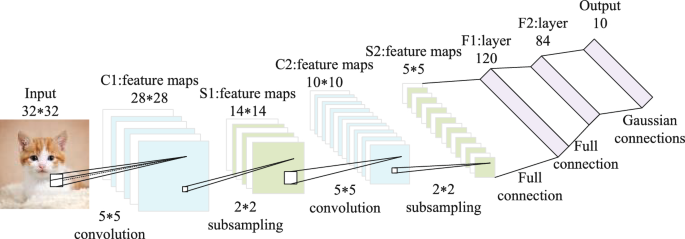

 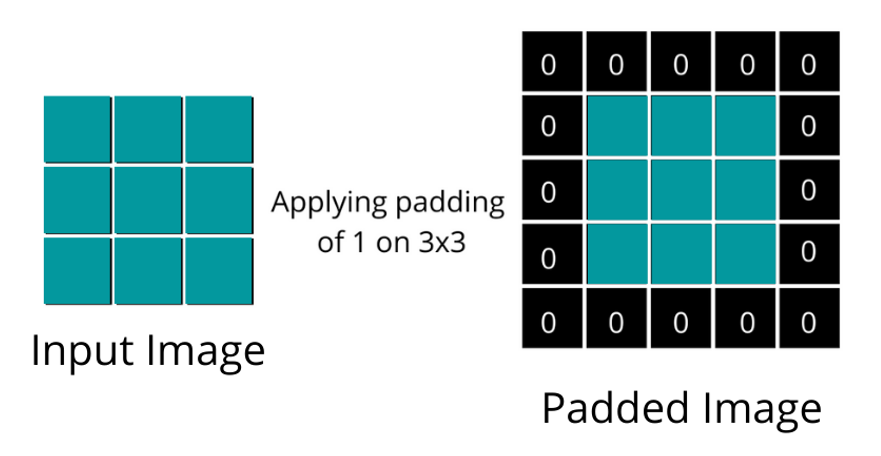

위 내용을 코드로 구현하여서, 숫자를 분류 해 보자.

해당 내용을 하기 전에 Auto Encoder 를 사용해서도 분류가 가능하다.

이 때는 Classification 을 하려고 만들어뒀던 Feature Vector 를 사용해서, 숫자를 분류하면 되기 때문에,

AE 와 CNN 의 성능 차이를 직접 한번 확인 해 보도록 하자.

직접 구현하지는 않을것이고, nn 내에 있는 Conv2d 함수를 사용할 것이다.

'''
nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
'''

- in_channels
  - 입력 채널의 개수 (최초 input 에서 RGB 이미지의 경우 3 Channel 이 된다.)

- out_channels
  - 출력되는 채널의 개수

- kernel_size
   - 컨볼루션 필터의 크기 (ex. 3*3 필터의 경우 3 으로 지정)

- stride
   - 필터의 이동 간격

- dilation
   - 필터의 간격을 더 크게 두는 옵션

- groups
   - 입력 및 출력 채널을 묶는 개수. 값이 커지면 채널간의 관련성을 줄인다.

- bias
   - 기본값은 True, False 로 설정하면 bias 값을 사용하지 않습니다.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

SAVE_DIR = "./saved_models"
AE_PATH = os.path.join(SAVE_DIR, "ae_classifier.pth")
CNN_PATH = os.path.join(SAVE_DIR, "cnn_classifier.pth")

def get_loaders(batch_size=128):
    transform = transforms.ToTensor()
    train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_data  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


# For Auto Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),          # 1x28x28 -> 784
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
        )

    def forward(self, x):
        return self.net(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, z):
        x_hat = self.net(z)
        return x_hat.view(-1, 1, 28, 28)


class AutoEncoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


# Auto Encoder 기반 Classification

class AEClassifier(nn.Module):
    """
    이미 학습된 Encoder를 받아서, Latent -> 10 클래스 분류
    """
    def __init__(self, encoder: Encoder, latent_dim=32, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

        self.classifier = nn.Linear(latent_dim, 10)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        return logits

In [3]:
# CNN 기반 분류기
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 1x28x28 -> 16x28x28
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 16x14x14
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 32x14x14
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 32x7x7
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [4]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def eval_classifier(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

In [5]:
# Auto Encoder 학습
def train_autoencoder(ae, train_loader, device, epochs=10, lr=1e-3):
    ae.to(device)
    optimizer = optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        ae.train()
        running_loss, total = 0.0, 0
        for x, _ in train_loader:     # 라벨 필요 없음
            x = x.to(device)
            x_hat, _ = ae(x)
            loss = criterion(x_hat, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += x.size(0)

        print(f"[AE] Epoch {epoch:2d}  Recon loss: {running_loss/total:.4f}")

In [7]:
def train_classifier(model, train_loader, test_loader, device,
                     epochs=5, lr=1e-3, name="cls"):
    model.to(device)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / total
        train_acc  = correct / total
        test_acc   = eval_classifier(model, test_loader, device)
        print(f"[{name}] Epoch {epoch:2d} "
              f"Train loss: {train_loss:.4f}, "
              f"Train acc: {train_acc:.4f}, "
              f"Test acc: {test_acc:.4f}")

    final_acc = eval_classifier(model, test_loader, device)
    print(f"[{name}] Final test accuracy: {final_acc:.4f}")
    return final_acc

In [ ]:
def run_train(latent_dim=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    os.makedirs(SAVE_DIR, exist_ok=True)

    train_loader, test_loader = get_loaders(batch_size=128)

    # Auto Encoder Train
    ae = AutoEncoder(latent_dim=latent_dim)
    print("AE total params:", count_params(ae))
    train_autoencoder(ae, train_loader, device, epochs=10, lr=1e-3)

    ae_classifier = AEClassifier(ae.encoder, latent_dim=latent_dim, freeze_encoder=True)
    print("AEClassifier trainable params (head only):", count_params(ae_classifier))

    print("\n=== Train classifier on AE latent (Encoder frozen) ===")
    acc_ae = train_classifier(
        ae_classifier, train_loader, test_loader,
        device, epochs=5, lr=1e-3, name="AE-CLS"
    )

    # CNN Train
    cnn = CNNClassifier()
    print("\nCNN Classifier params:", count_params(cnn))

    print("\n=== Train CNN classifier ===")
    acc_cnn = train_classifier(
        cnn, train_loader, test_loader,
        device, epochs=5, lr=1e-3, name="CNN"
    )

    torch.save(ae_classifier.state_dict(), AE_PATH)
    torch.save(cnn.state_dict(), CNN_PATH)
    print(f"\nSaved AE classifier to {AE_PATH}")
    print(f"Saved CNN classifier to {CNN_PATH}")

    print("\n=== Summary (train run) ===")
    print(f"AE latent classifier accuracy : {acc_ae:.4f}")
    print(f"CNN classifier accuracy       : {acc_cnn:.4f}")


In [11]:
def run_eval(latent_dim=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    _, test_loader = get_loaders(batch_size=128)

    # AE 기반 분류기 로드
    if not os.path.exists(AE_PATH) or not os.path.exists(CNN_PATH):
        print("No saved models found. 먼저 --mode train 으로 학습을 진행하세요.")
        return

    # ---- AE classifier load ----
    ae_enc = Encoder(latent_dim=latent_dim)
    ae_cls = AEClassifier(ae_enc, latent_dim=latent_dim, freeze_encoder=True)

    ae_state = torch.load(AE_PATH, map_location=device)
    ae_cls.load_state_dict(ae_state)
    ae_cls = ae_cls.to(device)

    acc_ae = eval_classifier(ae_cls, test_loader, device=device)

    # ---- CNN load ----
    cnn = CNNClassifier()
    cnn_state = torch.load(CNN_PATH, map_location=device)
    cnn.load_state_dict(cnn_state)
    cnn = cnn.to(device)

    acc_cnn = eval_classifier(cnn, test_loader, device=device)

    print("\n=== Evaluation of saved models ===")
    print(f"AE latent classifier accuracy : {acc_ae:.4f}")
    print(f"CNN classifier accuracy       : {acc_cnn:.4f}")

In [12]:
latent_dim = 32
run_train(latent_dim=latent_dim)
run_eval(latent_dim=latent_dim)

Device: cuda
AE total params: 439728
[AE] Epoch  1  Recon loss: 0.0518
[AE] Epoch  2  Recon loss: 0.0258
[AE] Epoch  3  Recon loss: 0.0210
[AE] Epoch  4  Recon loss: 0.0178
[AE] Epoch  5  Recon loss: 0.0156
[AE] Epoch  6  Recon loss: 0.0142
[AE] Epoch  7  Recon loss: 0.0131
[AE] Epoch  8  Recon loss: 0.0121
[AE] Epoch  9  Recon loss: 0.0114
[AE] Epoch 10  Recon loss: 0.0107
AEClassifier trainable params (head only): 330

=== Train classifier on AE latent (Encoder frozen) ===
[AE-CLS] Epoch  1 Train loss: 1.3421, Train acc: 0.6529, Test acc: 0.8598
[AE-CLS] Epoch  2 Train loss: 0.4659, Train acc: 0.8686, Test acc: 0.8900
[AE-CLS] Epoch  3 Train loss: 0.3949, Train acc: 0.8832, Test acc: 0.8977
[AE-CLS] Epoch  4 Train loss: 0.3678, Train acc: 0.8887, Test acc: 0.9011
[AE-CLS] Epoch  5 Train loss: 0.3543, Train acc: 0.8922, Test acc: 0.9013
[AE-CLS] Final test accuracy: 0.9013

CNNClassifier params: 105866

=== Train CNN classifier ===
[CNN] Epoch  1 Train loss: 0.3152, Train acc: 0.9080,

In [13]:
import matplotlib.pyplot as plt
import math

def show_sample_predictions(model, data_loader, device, num_samples=20, title_prefix=""):
    model.eval()
    model.to(device)

    images = []
    labels = []
    preds = []

    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            p = logits.argmax(dim=1)

            for i in range(x.size(0)):
                images.append(x[i].cpu())          # (1, 28, 28)
                labels.append(y[i].cpu().item())
                preds.append(p[i].cpu().item())
                if len(images) >= num_samples:
                    break
            if len(images) >= num_samples:
                break

    n = len(images)
    cols = 5
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 2.5, rows * 2.5))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        img = images[i].squeeze(0)  # (28, 28)
        ax.imshow(img, cmap="gray")
        gt = labels[i]
        pred = preds[i]
        correct = (gt == pred)
        ax.set_title(f"GT:{gt} / Pred:{pred}\n{'✔' if correct else '✘'}",
                     fontsize=10, color=("green" if correct else "red"))
        ax.axis("off")

    if title_prefix:
        plt.suptitle(title_prefix, fontsize=16)
    plt.tight_layout()
    plt.show()

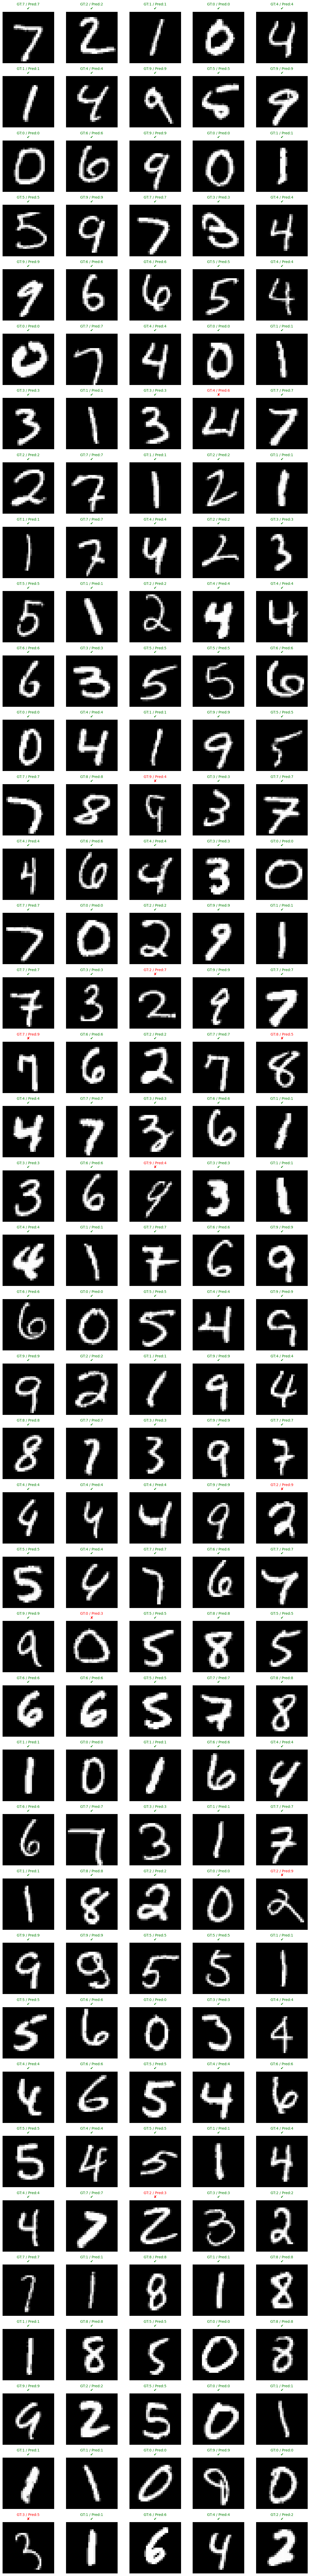

In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, test_loader = get_loaders(batch_size=128)

latent_dim = 32

ae_enc = Encoder(latent_dim=latent_dim)
ae_cls = AEClassifier(ae_enc, latent_dim=latent_dim, freeze_encoder=True)

ae_state = torch.load(AE_PATH, map_location=device)
ae_cls.load_state_dict(ae_state)
ae_cls = ae_cls.to(device)

show_sample_predictions(
    ae_cls, test_loader, device,
    num_samples=200,
    title_prefix=""
)

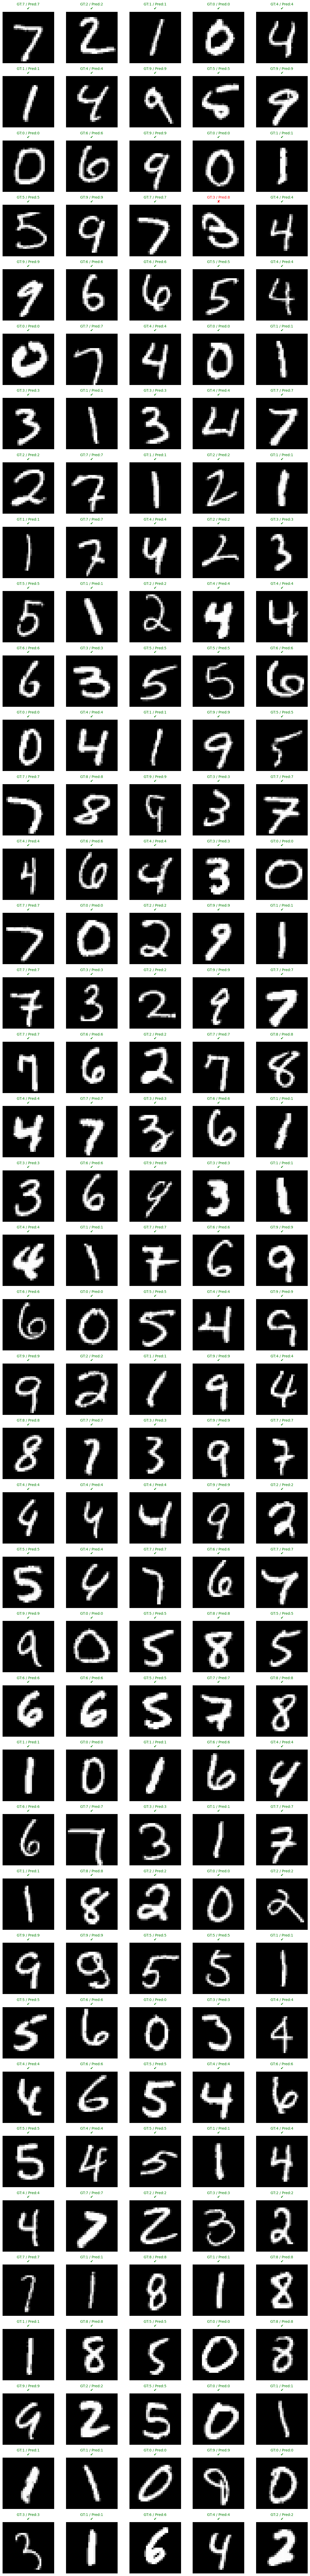

In [18]:
cnn = CNNClassifier()
cnn_state = torch.load(CNN_PATH, map_location=device)
cnn.load_state_dict(cnn_state)
cnn = cnn.to(device)

show_sample_predictions(
    cnn, test_loader, device,
    num_samples=200,
    title_prefix=""
)

AE total params: 439728
AEClassifier trainable params (head only): 330
 - AE (Encoder + Classifier) = 439728 / 2 + 330 = 220194
 - 실제로는 디코더가 인코더보다 살짝 더 커서, 100단위 숫자가 좀 차이가 난다. 하지만 거의 절반이라고 계산해도 무방하다!
 - 중요한 것은 CNN 보다 2배의 Parameter 를 가지고 분류 하고 있다는 것이 중요함.
CNN Classifier params: 105866

### Accuracy
AE latent classifier accuracy : 0.9013

CNN classifier accuracy       : 0.9885


이렇게 모델을 잘 만들면

Parameter 가 절반밖에 안되어도, 정확도가 훨씬 높게 찍히는 것을 볼 수 있다.